# Image classification (plant pathology)

## Task
Apple leaf diseases identification. The collection includes photos with diseases:

- apple rust
- apple scab
- several diseases occurring simultaneously (combinations)

and photos of healthy leaves.

## Data
Data from the website:
https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

Contents:
1. The train.csv file
- image_id - image ID
- healthy - healthy leaves
- multiple_diseases - several diseases at the same time
- rust - apple rust
- scab - apple scab
2. The images folder
Folder containing training and test files in JPG format

3. The test.csv file
- image_id - image ID

4. File sample_submission.csv - file with the application pattern for the Kaggle competition (not used here)

In [1]:
# Importing libraries
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Eksploratory data analysis

In [2]:
# Getting the training data
train_df = pd.read_csv("/content/drive/MyDrive/plant_pathology/train.csv")
train_df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [3]:
# WGetting the test data
test_df = pd.read_csv("/content/drive/MyDrive/plant_pathology/test.csv")
test_df

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


We have no missing values. There are 5 columns, the first (image_id) is of the "object" type and the rest are of the int64 type. We have 1,821 rows corresponding to 1,821 photos. In the folder with photos we have 3642 photos, 1821 training and 1821 test photos.

In [5]:
train_df.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


There is nothing disturbing here (for example wrong indication by giving value other than 0/1).

In [6]:
train_df.healthy.value_counts(), train_df.multiple_diseases.value_counts(), train_df.rust.value_counts(), train_df.scab.value_counts()

(0    1305
 1     516
 Name: healthy, dtype: int64, 0    1730
 1      91
 Name: multiple_diseases, dtype: int64, 0    1199
 1     622
 Name: rust, dtype: int64, 0    1229
 1     592
 Name: scab, dtype: int64)

We have exactly as many markings (1) as there are photos, so everything is correct. The data is not balanced because there are much fewer photos with multiple diseases. For now, however, we will leave it like that.

Let's see some picture with the size shown.

(1365, 2048, 3)


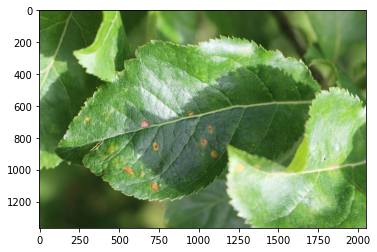

In [7]:
img_1 = plt.imread("/content/drive/MyDrive/plant_pathology/images/Test_1.jpg")
print(img_1.shape)
plt.imshow(img_1);

(1365, 2048, 3)


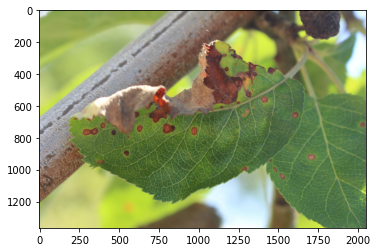

In [8]:
img_2 = plt.imread("/content/drive/MyDrive/plant_pathology/images/Train_1.jpg")
print(img_2.shape)
plt.imshow(img_2);

Path lists and labels preparation for modeling.

In [9]:
train_paths = ["/content/drive/MyDrive/plant_pathology/images/" + fname + ".jpg" for fname in train_df["image_id"]]
train_paths[:15]

['/content/drive/MyDrive/plant_pathology/images/Train_0.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_1.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_2.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_3.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_4.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_5.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_6.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_7.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_8.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_9.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_10.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_11.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_12.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_13.jpg',
 '/content/drive/MyDrive/plant_pathology/images/Train_14.jpg']

In [10]:
train_labels = np.float32(train_df.iloc[:, 1:].values)
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

From the training set, we will separate a training and validation set on which we will check the model. The test set in this set is only a photo ID, so if we were training the model on the entire training set, we would not be able to check it.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=37)

Function to prepare images for training the model.

In [12]:
def preprocess_image(filename, label=None, img_size = (224, 224)):
  """
  Takes the photo path and prepares it for neural network training:
   - converts the photo into 8-bit tensor
   - changes unit8 to float32 and normalizes by division by max
   - changes the size of the photo to the given size
   The function returns a tuple (image, label)
  """
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
  image = tf.image.resize(image, img_size)
  return image, label


Preparing data sets from input data for training and validation.

In [13]:
BATCH_SIZE = 32

train_data = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

valid_data = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

# Convolutional neural networks architectures

The Sequential model was chosen to define it step by step by adding new layers in the architecture. It is supposed to be the simplest possible model, hence this approach in the first place. We will use the same convolutional layers, together with 2D scaling, and then, after "flattening" the data, we will go to the densified layers, the last of which will have a size corresponding to the number of classes to be obtained.

In [ ]:
model = Sequential([
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPool2D(),
      layers.Flatten(),       
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(4, activation='softmax' )
])

Model compilation using the 'Adam' optimizer which is currently one of the most effective and widely used optimizers. The loss function "Categorical Crossentropy" is used with more than two classes (where we would use Binary Crossentropy). We will use the 'accuracy' metric (number of correctly predicted classes). 

We can additionally use the EarlyStopping function, which prevents overfitting. I trained the first models without EarlyStopping, but in later epochs nothing has changed, so this function has been added in order not to count the model for too long.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                   patience = 3)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Let's test the model on previously prepared sets (assigning it to history so that we can check the learning process)

In [ ]:
history = model.fit(train_data,
                    epochs=50,
                    validation_data=valid_data,
                    callbacks = [early_stopping])

Epoch 1/50
46/46 [==============================] - 53s 1s/step - loss: 1.2899 - accuracy: 0.3098 - val_loss: 1.2385 - val_accuracy: 0.3342
Epoch 2/50
46/46 [==============================] - 52s 1s/step - loss: 1.2520 - accuracy: 0.3201 - val_loss: 1.2338 - val_accuracy: 0.3699
Epoch 3/50
46/46 [==============================] - 53s 1s/step - loss: 1.2500 - accuracy: 0.3228 - val_loss: 1.2335 - val_accuracy: 0.3699
Epoch 4/50
46/46 [==============================] - 51s 1s/step - loss: 1.2492 - accuracy: 0.3345 - val_loss: 1.2326 - val_accuracy: 0.3699
Epoch 5/50
46/46 [==============================] - 52s 1s/step - loss: 1.2484 - accuracy: 0.3345 - val_loss: 1.2323 - val_accuracy: 0.3699


Training proces graphs

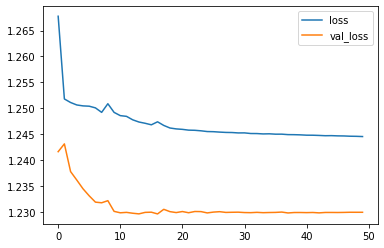

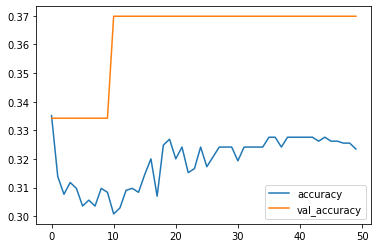

In [ ]:
history_plot = pd.DataFrame(history.history)
history_plot.loc[:, ['loss', 'val_loss']].plot()
history_plot.loc[:, ['accuracy', 'val_accuracy']].plot();

As we can see, the first attempt was not very successful. Both the accuracy and the loss function differ significantly. In addition, we can see a very large irregularity here.
Let's try a different model.

In [ ]:
model1 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224, 224, 3)),
      layers.Conv2D(32, 3, padding='valid', activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, padding='valid', activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPool2D(),
      layers.Flatten(),       
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(4, activation='softmax' )
])

In [ ]:
# Using experimental.preprocessing we can see the summary of the model before running it.
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 54, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 64)       

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model1.fit(train_data,
                    epochs=50,
                    validation_data=valid_data,
                    callbacks = [early_stopping])

Epoch 1/50
46/46 [==============================] - 55s 1s/step - loss: 1.2815 - accuracy: 0.3201 - val_loss: 1.2305 - val_accuracy: 0.3699
Epoch 2/50
46/46 [==============================] - 54s 1s/step - loss: 1.2494 - accuracy: 0.3276 - val_loss: 1.2318 - val_accuracy: 0.3699
Epoch 3/50
46/46 [==============================] - 54s 1s/step - loss: 1.2500 - accuracy: 0.3242 - val_loss: 1.2340 - val_accuracy: 0.3699
Epoch 4/50
46/46 [==============================] - 55s 1s/step - loss: 1.2501 - accuracy: 0.3214 - val_loss: 1.2334 - val_accuracy: 0.3699


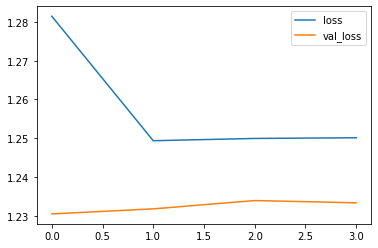

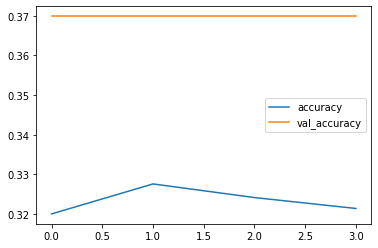

In [ ]:
history_plot = pd.DataFrame(history.history)
history_plot.loc[:, ['loss', 'val_loss']].plot()
history_plot.loc[:, ['accuracy', 'val_accuracy']].plot();

The second model was equally bad. The only improvement was in regularity with accuracy.
Using example solutions, we will train the model using normalization during training with BatchNormalization after each convolutional layer.

In [17]:
model2 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224, 224, 3)),
layers.Conv2D(64, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.Conv2D(64, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.MaxPooling2D((3, 3)),
layers.Conv2D(128, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.Conv2D(128, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(256, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.Conv2D(256, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(512, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.Conv2D(512, (3, 3), activation ='relu', padding = 'same'),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(512, activation = "relu"),
layers.BatchNormalization(),
layers.Dense(4, activation = "softmax")
])

In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 74, 74, 128)      

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model2.fit(train_data,
                    epochs=50,
                    validation_data=valid_data)

Epoch 1/50
46/46 [==============================] - 59s 1s/step - loss: 1.6734 - accuracy: 0.4183 - val_loss: 1.3129 - val_accuracy: 0.3342
Epoch 2/50
46/46 [==============================] - 57s 1s/step - loss: 0.9686 - accuracy: 0.6016 - val_loss: 2.0500 - val_accuracy: 0.2493
Epoch 3/50
46/46 [==============================] - 58s 1s/step - loss: 0.6880 - accuracy: 0.7266 - val_loss: 2.9167 - val_accuracy: 0.2493
Epoch 4/50
46/46 [==============================] - 56s 1s/step - loss: 0.5056 - accuracy: 0.7995 - val_loss: 3.8126 - val_accuracy: 0.2493
Epoch 5/50
46/46 [==============================] - 58s 1s/step - loss: 0.3628 - accuracy: 0.8633 - val_loss: 4.8687 - val_accuracy: 0.2493
Epoch 6/50
46/46 [==============================] - 59s 1s/step - loss: 0.3205 - accuracy: 0.8805 - val_loss: 4.1554 - val_accuracy: 0.2493
Epoch 7/50
46/46 [==============================] - 59s 1s/step - loss: 0.2628 - accuracy: 0.9066 - val_loss: 5.7061 - val_accuracy: 0.2493
Epoch 8/50
46/46 [==

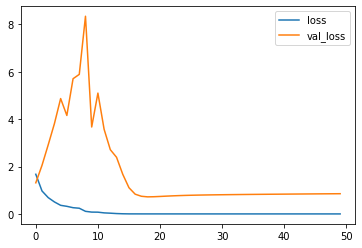

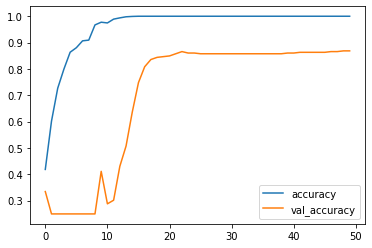

In [ ]:
history_plot = pd.DataFrame(history.history)
history_plot.loc[:, ['loss', 'val_loss']].plot()
history_plot.loc[:, ['accuracy', 'val_accuracy']].plot();

#### We can see here a significant improvement in terms of training the model. The accuracy and loss values for the training set indicate that the model has trained very well on the training data and is 100% sure of what it "sees". It is a bit different with the values for val_loss and val_accuracy. Despite the fact that the model very decently predicts the validation set (about 86% of the effectiveness), in this case there is no such certainty as to the prediction. The model has not learned to generalize that well, which may result in worse outcomes if it is provided with new data.

#### Next steps to be taken:
#### The first thing to do is to enlarge the data set by "data augmentation", i.e. randomly rotating, zooming, adding color, etc. Thanks to this, we will get a more diverse set which should help in better generalization and achieving similar results on the training and validation sets (with low error values on both sets).
#### After that we should also pay attention to whether the model is not over-trained or under-trained.